## Cool Star Lab, UCSD   
## Joman, 28 July, 2022  
---

### imports 

In [1]:
import splat
from splat.plot import plotSpectrum



Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
splat.VERSION

'2022.07.05'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
from scipy import stats as scipy
from scipy import interpolate
import math
from numpy.linalg import eig

from astropy.io import fits
import astropy.units as u # units

---

### Helper Functions

In [4]:
def saveTemplate(name:str, template_names:np.array):
    TEMPLATE_NAMES[name] = template_names
    temp = []
    for item in template_names:
        sp = splat.Spectrum(filename= template_dir + '/' + item + '.fits')
        temp.append(sp)
    TEMPLATE_SPECS[name] = temp
    TEMPLATE_DICT[name] = (template_names,temp)

In [5]:
def spline_fit(spec, wave_range = [0.85, 2.45]):
    '''
    perform cubic spline interpolation, separating into 0.05 micron wave increments from 0.85 to 2.45 microns by default
    Goal is to reduce the influence of noise or missing points.
    '''
    
    low_range = wave_range[0]
    high_range = wave_range[1]
        
    # Removing the units
    x = spec.wave/u.micron
    y = spec.flux
    
    tck = interpolate.splrep(x, y, s=0) # spline prep, parameters to plot the interpolation 
    # Side note, not all spectrrum data encompasses 0.45 - 2.45 microns. Default k = 3 (cubic), as in source material
    xnew = np.arange(low_range, high_range, 0.05) # separating the wavelengths into 0.05 micron increments, from 0.85 - 2.45
    ynew = interpolate.splev(xnew, tck, der=0) # using the spline prep, obtain the "best fit" reflectance values
    
    # plots the resulted spline best fit with the original
    plt.figure()
    plt.plot(x, y, xnew, ynew)
    plt.legend(['True','spline'])
    plt.title('Cubic-spline interpolation')
    plt.show()
    
    return (xnew, ynew, tck)

In [6]:
def norm_splined(xx, yy, tck, norm = 1.2):
    '''
    Normalize the data at 1.2 micron wavelength. But the slope obtained with linear regression later is not dependent on the wavelength 
    which data is normalized (according to Demeo).
    '''
    yy_val = interpolate.splev(np.array([norm]), tck, der=0)
    yynew = yy/yy_val # now, 0.75 micron reflectance value = 1
    xxnew = xx
    return xxnew, yynew

In [7]:
def lin_regress(xxnew, yynew):
    '''
    Using linear regression, slope of that data is calculated.
    '''
    nom = np.sum((xxnew - np.mean(xxnew))*(yynew - np.mean(yynew)))
    denom = np.sum((xxnew - np.mean(xxnew))**2)
    gamma = nom/denom
    return gamma

In [8]:
def form_data_pairs(obj_list, wave_range = [0.85, 2.45], norm = 1.2):
    '''
    Perform data preperation, returns list of arrays with 2 arrays, one of which is the wavelength channels, the other, 
    the normalized spline spectra divided by the linear regression slope
    '''
    
    tp_list = [] 
    for obj in obj_list:
        tp_x = obj.wave/u.micron
        tp_y = obj.flux
        # obtain variables from cubic spline fitting
        tp_xx, tp_yy, tp_spline_vars = spline_fit(obj, wave_range)
        # normalize the data at some wavelength define by 'norm'
        tp_xxnew, tp_yynew = norm_splined(tp_xx, tp_yy, tp_spline_vars, norm = norm)
        # calculate the slope of data using linear regression
        tp_slope = lin_regress(tp_xxnew, tp_yynew)
        
        # normalized at 'norm' microns, here we translate the regression line to pass through (norm, 1)
        tp_reg_line = tp_xxnew*tp_slope + (1 - tp_slope*norm)
        # dividing out the slope using the line we just defined
        tp_yynew_no_slope = tp_yynew/tp_reg_line
        # add to list, and return an array of wavelength-(slope removed)reflectance pairs
        tp_list.append((tp_xxnew, tp_yynew_no_slope))
    return np.array(tp_list), tp_slope, tp_reg_line

In [9]:
def subtract_data(data_pairs):
    '''
    Subtracts mean of each wavelength channel from every entry of that channel, such that mean = 0, returns the subtracted data with
    the channel selected for unity removed. This operation is for creating new PCs, not classifying an asteroid.
    '''
    number_of_objs = data_pairs.shape[0]
    summing_spec = np.array(data_pairs[0][1])
    for pair in data_pairs[1:]:
        summing_spec = summing_spec + pair[1]

    channel_means = summing_spec/number_of_objs

    # prepare mean subtracted data
    mean_subtracted_data = []
    for pair in data_pairs:
        mean_subtracted_data.append(pair[1] - channel_means)
    subtracted_data_matrix = np.array(mean_subtracted_data) # rows of entries from different targets, cols of values for each wavelength

    # transpose the matrix to fit PCA mathematics, where subtracted_data_matrix is now rows of measured 
    # reflectance values at some wavelength, where columns record entries from different targets
    subtracted_data_matrix = subtracted_data_matrix.T
    subtracted_data_matrix = np.delete(subtracted_data_matrix, 7, axis=0) # row id 7 is the wavelength where we have normalized to unity (1.2)
    
    return subtracted_data_matrix

In [10]:
def calculate_pc_scores(subtracted_data_matrix):
    '''
    Calculate the principal components (x number of wavelength channels of components), returns an array of the principal components of objs.
    A number, aka "score" for an obj for each component is stored at the corresponding column position to each row. This generates the correspondings
    eigenvectors for the PCs.
    '''
    number_of_objs = subtracted_data_matrix.shape[1]
    covariance_matrix = np.dot(subtracted_data_matrix,subtracted_data_matrix.T)/number_of_objs


    # finding eigenvectors of the covariance_matrix

    covariance_eigenvalues, covariance_eigenvectors = eig(covariance_matrix)


    # percentages for each PC's information

    eigenvalue_sum = np.sum(covariance_eigenvalues)
    principal_component_information = covariance_eigenvalues/eigenvalue_sum
    five_pcs = ''
    for k in np.arange(5):
        tp_float = principal_component_information[k]*100
        five_summed = np.sum(principal_component_information[:5])*100
        five_pcs += 'PC' + str(k+1) + ' ' + str(float(f'{tp_float:.2f}')) + '%    '
    print(five_pcs + '\n'+'Information in first 5 PCs:' + str(float(f'{five_summed:.2f}')) + '%')
    
    # computing principal components
    # PC_x = Eigenvector^T * subtracted_data_matrix_column^T

    principal_components = []
    for i in np.arange(covariance_eigenvectors.shape[0]):
        tp_one_component = []
        for j in np.arange(subtracted_data_matrix.shape[1]):
            tp_one_component.append(np.dot(covariance_eigenvectors[i].T,subtracted_data_matrix[:,j].T)) # a number, aka "score" for an obj, 
            # is added to a temporary list storing the scores of objs for a specific PC.
        principal_components.append(tp_one_component) # adds the list of scores for a particular PC to the gross list

    return np.array(principal_components)

In [11]:
def MITHNEOS_to_Spectrum(txtPath):
    '''
    Downloading data from MITHNEOs as a .txt file contains both V and NIR data, as well as numbers
    indicating what are the omitted rows. This function takes a string for the path of a file and
    returns a splat.Spectrum object constructed with the data in that file.
    
    '''
    
    data = open(txtPath, 'r')

    objName = txtPath.split("/")[len(txtPath.split("/"))-1]

    dataString = data.read()

    # MITHNEOS data contains V band as well, NIR data is always separated by an extra new line after the V band
    ir_only_data = dataString.split('\n\n')

    if len(ir_only_data) > 1:
        ir_only_data = ir_only_data[1]
    else:
        ir_only_data = ir_only_data[0]

    dataList = ir_only_data.split("\n")

    # removing entries with 0 in "number of frames used to obtain data", noted as excluded values on MITHNEOS
    pruned_dataList = []
    for entry in dataList:
        if entry is not '': # ignores empty rows
            if (float(entry[len(entry)-1]) != 0): 
                pruned_dataList.append(entry.split()) # strings, of each value

    # pruned_dataList is a list of lists, of which the smaller list are rows of the .txt file
    # "Wavelength","reflectance", "sigma1", "# of frames"
    # casting strings to floats and constructing the columns we need, wave, flux, (and uncertainty)

    wavelengths = [] # wavelength
    flx = [] # reflectance
#     sig1 = [] # sigma 1 uncertainty 

    for row in pruned_dataList:
        wavelengths.append(float(row[0]))
        flx.append(float(row[1]))
#         sig1.append(float(row[2]))

    spwave = np.array(wavelengths)
    spflux = np.array(flx)
#     spone_sigma = np.array(sig1)

    sp = splat.Spectrum(wave=spwave,flux=spflux, flux_unit=u.dimensionless_unscaled)
    sp.name = objName
    
    return sp

In [12]:
def load_demeo_pcs(pcs_path):
    '''
    This is what was done to obtain the eigenvectors from Demeo's supplementary materials, saved as a .txt file
    at pcs_path. Returns 2 arrays.
    
    prints: demeo_ev_channels = [] - allows user to check ordering of wavelengths was loaded correctly
    
    Returns:
    An array of arrays containing:
        demeo_pc1 - principle component 1
        demeo_pc2 - principle component 2
        demeo_pc3 - principle component 3 
        demeo_pc4 - principle component 4
        demeo_pc5 - principle component 5
    and an array:
    demeo_chn_means - the mean values of each wavelength channel used in obtaining the eigenvectors, 
                        and necrssary in calculating a PC score
    '''
    
    # reading the eigenvectors and mean values txt file
    with open(pcs_path) as f:
        eigv_and_means = str(f.readlines())
    eigv_and_means = eigv_and_means.split()

    # removing the headers
    eigv_and_means = eigv_and_means[11:]

    demeo_ev_channels = []
    demeo_pc1 = []
    demeo_pc2 = []
    demeo_pc3 = []
    demeo_pc4 = []
    demeo_pc5 = []
    demeo_chn_means = []

    for item in eigv_and_means:
        temp = item.split('\\n') # removing the "new line" before each new channel entry
        temp = temp[0].split('\\t') # removing the tab white spaces between values

        demeo_ev_channels.append(float(temp[0][1:])) # optional, allows us to check the order of the channels being handeled corresponding to the PCs 
        demeo_pc1.append(float(temp[1]))
        demeo_pc2.append(float(temp[2]))
        demeo_pc3.append(float(temp[3]))
        demeo_pc4.append(float(temp[4]))
        demeo_pc5.append(float(temp[5]))
       
        # the mean values of Demeo's data, which was used to obtain the PC's eigenvectors
        # this is necessary in calculating the PC scores for each Spectrum
        demeo_chn_means.append(float(temp[6].split('\'')[0])) 
    
    # wavelength channels
    demeo_ev_channels = np.array(demeo_ev_channels)
    print('wavelengths: ', demeo_ev_channels)
    
    # means of each channel
    demeo_chn_means = np.array(demeo_chn_means)
    
    return np.array([demeo_pc1,demeo_pc2,demeo_pc3,demeo_pc4,demeo_pc5]),demeo_chn_means

In [13]:
def get_scores(pcs, subtracted_reflectance):
    '''
    Calculate PC scores of a spectrum given the PC eigenvectors, returns an array of scores. This function is different from calculate_pc_scores as this 
    function calculates scores based on given eigenvectors, and does not generate new eigenvectors using a set of data.
    '''
    score_list = []
    for pc in pcs:
        score_list.append(np.dot(pc.T, subtracted_reflectance.T))

    return np.array(score_list)

---
### Main Classification routine

In [14]:
def classifyAsteroid(spectrum_path, waverange = [0.85, 2.45], norm = 1.2, plot = False, verbose = False):
    '''
    Classify asteroid given a .txt file
    '''
    
    # creating a splat.Spectrum Object
    sp = MITHNEOS_to_Spectrum(spectrum_path)
    
    # preparing the object, cubic spline, dividing out the slope
    sp_reduced, slope_value, slope_line = form_data_pairs([sp], waverange, norm)
    sp_reflectance = sp_reduced[0][1]
    # subtracting the reflectance by mean values from Demeo's classification definition
    subtracted_sp_reflectance = sp_reflectance - CHANNEL_MEANS
    # calculate the PC scores from the PC1- PC5
    pc_scores = get_scores(PC_VECTORS, subtracted_sp_reflectance)

    if plot:
        sp_re_wave = sp_reduced[0][0]
        reconstructed_flux = (np.dot(pc_scores, PC_VECTORS) + CHANNEL_MEANS)*slope_line

        sp_with_norm_spline = splat.Spectrum(wave=sp_reduced[0][0], flux=sp_reflectance*slope_line)
        sp_with_norm_spline.plot(label =' After nornalizing to unity at ' + str(norm))
        sp_re = splat.Spectrum(wave = sp_re_wave, flux = reconstructed_flux)
        sp_re.plot(label = 'Reconstruction using components', color ='#2A46A3')
   
    if verbose:    
        reconstructed_flux = (np.dot(pc_scores, PC_VECTORS) + CHANNEL_MEANS)*slope_line
        
        print("Flux after normalizing cubic spline fit: \n", sp_reflectance*slope_line)
        print("Reconstructed flux: \n", reconstructed_flux)
        
    verdict = classifyStep1(pc_scores, slope_value)
    print(sp.name)
    print('Slope: ' + str(slope_value))
    print('PC Scores:', pc_scores)
    print('Verdict:', verdict)
    
    return verdict

In [15]:
def classifyStep1(pc_scores, slope):
    '''
    IR step 1: End members
    
    PCir3 = PCir2 − 0.08  Line 1  
    PCir1 = PCir2 + 0.15  Line 2  
    PCir1 = PCir2 − 0.10  Line 3  
    PCir1 = PCir2 − 0.40  Line 4 
    '''
    PC1, PC2, PC3, PC4, PC5 = pc_scores
    
    line1 = PC2 - 0.08
    line2 = PC2 + 0.15
    line3 = PC2 - 0.10
    line4 = PC2 - 0.40
    
    if(PC3 >= line1):
        on_or_above_line1 = True
    else:
        on_or_above_line1 = False
        
    if(PC1 >= line2):
        on_or_above_line2 = True
    else:
        on_or_above_line2 = False
    
    if(PC1 >= line3):
        on_or_above_line3 = True
    else:
        on_or_above_line3 = False
    
    if(PC1 >= line4):
        on_or_above_line4 = True
    else:
        on_or_above_line4 = False
    
    line_positions = [on_or_above_line1, on_or_above_line2, on_or_above_line3, on_or_above_line4]
    
    # End Members
    if(PC1 >= 0.5):
        return 'V'
    elif((0.29 <= PC1 < 0.5) and (PC5 <= 0.05)):
        return 'Sv, Sr'
    elif((PC2 <= -0.5) and (PC4 >= 0.15) and (-0.40 < PC1 <= 0)):
        return 'O'
    elif((0.25 <= PC2 < 0.5) and (PC5 >= 0.06) and (PC3 >= 0.05)):
        return 'R'
    elif(not on_or_above_line1 and (slope >= 0.24)):
        return 'D'
    elif((PC1 <= -0.4) and (PC2 <= -0.2) and (PC4 >= -0.07) and (slope >= 0.5) and (PC3 >= 0)):
        return 'A'
    elif(PC1 <= -0.4):
        return 'Sa'
    else:
        return classifyStep2(pc_scores, line_positions)

In [16]:
def classifyStep2(pc_scores, line_positions):
    '''
    IR step 2: S-complex

    PCir3 = PCir2 − 0.08  Line 1  
    PCir1 = PCir2 + 0.15  Line 2  
    PCir1 = PCir2 − 0.10  Line 3  
    PCir1 = PCir2 − 0.40  Line 4 
    '''
    PC1, PC2, PC3, PC4, PC5 = pc_scores
    on_or_above_line1, on_or_above_line2, on_or_above_line3, on_or_above_line4 = line_positions
    
    line3 = PC2 - 0.10
    line4 = PC2 - 0.40
    
    if(PC1 == line3):
        on_line3 = True
    else:
        on_line3 = False
    
    if(PC1 == line4):
        on_line4 = True
    else:
        on_line4 = False
    
    if(on_or_above_line1 and on_or_above_line2): # on or above line 1 and 2
        return 'S, Sr, Sq, Q'
    elif(on_or_above_line1 and (not on_or_above_line2 and on_or_above_line3)): # on or above line 1 and between line 2 and line 3, line 2 is always > line 3
        return 'S, Sq, Q, L, K'
    elif(on_or_above_line1 and ((on_or_above_line4 and not on_or_above_line3) or (on_line3) or (on_line4))): # on or above line 1 and on or between line 3 and 4
         return 'K, L, Sq'
    else:
        return classifyStep3(pc_scores, line_positions)

In [17]:
def classifyStep3(pc_scores, line_positions):
    '''
    IR step 3: C- and X-complexes
    
    PCir3 = PCir2 − 0.08  Line 1  
    PCir1 = PCir2 + 0.15  Line 2  
    PCir1 = PCir2 − 0.10  Line 3  
    PCir1 = PCir2 − 0.40  Line 4 
    '''
    PC1, PC2, PC3, PC4, PC5 = pc_scores
    on_or_above_line1, on_or_above_line2, on_or_above_line3, on_or_above_line4 = line_positions
    
    line2 = PC2 + 0.15
    line3 = PC2 - 0.10
    line4 = PC2 - 0.40
    
    if(PC1 == line2):
        on_line2 = True
    else:
        on_line2 = False
    
    if(PC1 == line3):
        on_line3 = True
    else:
        on_line3 = False
    
    if(PC1 == line4):
        on_line4 = True
    else:
        on_line4 = False
    
    if((not on_or_above_line1) and ((on_or_above_line4 and not on_or_above_line3) or (on_line3) or (on_line4))): # below line 1 and on or between line 3 and 4
        return 'X-, C-complexes, L, K, T'
    elif((not on_or_above_line1) and (on_or_above_line3 and not on_or_above_line2) and not on_line3): # below line 1 and between 2 and 3
        return 'X-, C-complexes'
    elif((not on_or_above_line1) and (not on_or_above_line4)):
        return 'C, B, L, Cb, X'
    else:
        return 'Indeterminate'

---

### Setup

In [18]:
PATH = os.getcwd()
PCS_PATH = PATH + '/demeo_ir_eigenvectors_and_channel_means.txt'

# obtaining the principal component eivenvectors of the classification scheme from a .txt file
PC_VECTORS, CHANNEL_MEANS = load_demeo_pcs(PCS_PATH)

wavelengths:  [0.85 0.9  0.95 1.   1.05 1.1  1.15 1.25 1.3  1.35 1.4  1.45 1.5  1.55
 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25
 2.3  2.35 2.4  2.45]


___

### Examples

---

### (53435) 1999 VM40, Demeo et al. 2099 doi:10.1016/j.icarus.2009.02.005 -- Srw

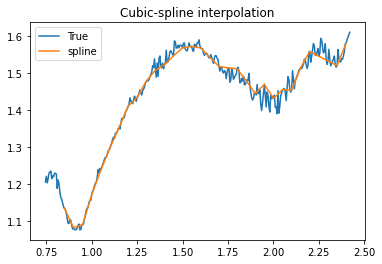

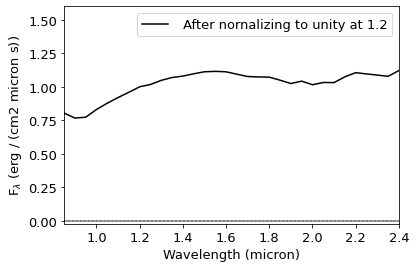

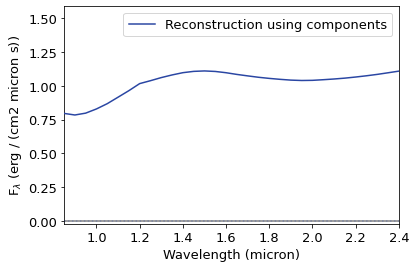

Flux after normalizing cubic spline fit: 
 [0.80388818 0.76692209 0.77281113 0.8305662  0.87767844 0.91996594
 0.9593444  1.         1.01731233 1.04824748 1.06911811 1.0799631
 1.09692068 1.11217539 1.11508443 1.11196254 1.09394068 1.07662835
 1.07371931 1.07201646 1.04921512 1.02440755 1.04221655 1.01532567
 1.03214134 1.03136086 1.07442883 1.10550589 1.09592734 1.08741308
 1.0780474  1.12132822]
Reconstructed flux: 
 [0.79508418 0.78341602 0.79712835 0.82826042 0.86731061 0.91530286
 0.96354748 1.01579653 1.03735883 1.06029634 1.07989547 1.09666266
 1.10633806 1.10956563 1.10575477 1.0963132  1.08377469 1.07294715
 1.06266944 1.05434993 1.04739098 1.04162657 1.03884146 1.03996682
 1.04459532 1.04992656 1.05632142 1.06450056 1.0737108  1.08405468
 1.095975   1.10818671]
a053435.sp272.txt
Slope: 0.15767329177920741
PC Scores: [ 0.17381262 -0.08981869 -0.08085877 -0.03832494 -0.04077956]
Verdict: S, Sr, Sq, Q


'S, Sr, Sq, Q'

<Figure size 432x288 with 0 Axes>

In [19]:
classifyAsteroid('D:\\PythonCodes\\JupyterWorkspace\\splat_projects/MITHNEOS_data/sp272/a053435.sp272.txt', plot=True, verbose = True)

---

### (17274) 2000 LC16,  Demeo et al. 2009 doi:10.1016/j.icarus.2009.02.005 -- D

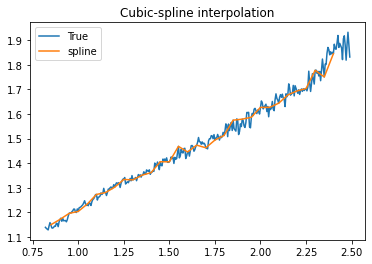

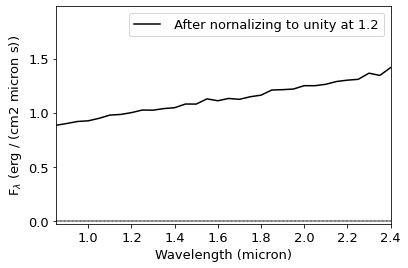

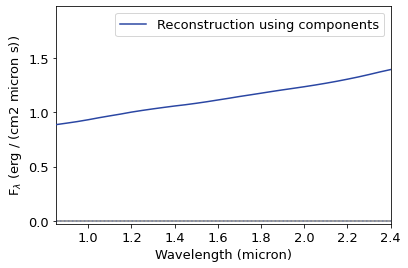

a017274.sp02.txt
Slope: 0.3134869433788578
PC Scores: [-0.13033222  0.20058816  0.05564393  0.00579876 -0.01655471]
Verdict: D


'D'

<Figure size 432x288 with 0 Axes>

In [20]:
classifyAsteroid('D:\\PythonCodes\\JupyterWorkspace\\splat_projects/MITHNEOS_data/sp02/a017274.sp02.txt', plot = True)

---

### (326777) 2003 SV222

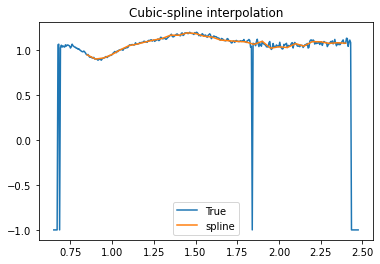

Flux after normalizing cubic spline fit: 
 [0.86829581 0.8254622  0.83699433 0.87241442 0.920648   0.96183416
 0.97803405 1.         1.01940326 1.035054   1.06873513 1.0679994
 1.092257   1.08539264 1.0586674  1.04905729 1.01876258 1.0121728
 1.00539996 1.00091525 0.97464763 1.00640674 0.93629874 0.95030203
 0.9431631  0.98233571 0.95734944 1.00292879 1.00137287 0.98553908
 0.99157972 0.98691195]
Reconstructed flux: 
 [0.86221663 0.83901769 0.84399942 0.86897555 0.89989329 0.936461
 0.97317794 1.0152699  1.03205575 1.05001109 1.06343339 1.07332192
 1.07594022 1.07219215 1.06138779 1.04609283 1.02815824 1.01216615
 0.99777175 0.98670332 0.97781632 0.97061201 0.96662204 0.96700448
 0.97050877 0.974284   0.97778795 0.98140325 0.98467135 0.98812821
 0.99226659 0.99604518]
a326777.sp256n1.txt
Slope: 0.04247695200202994
PC Scores: [ 0.11957737 -0.06009511 -0.04269531 -0.01235879 -0.01612116]
Verdict: S, Sr, Sq, Q


'S, Sr, Sq, Q'

In [21]:
classifyAsteroid('D:\\PythonCodes\\JupyterWorkspace\\splat_projects/MITHNEOS_data/sp256/a326777.sp256n1.txt', verbose = True)

---

### (22099) 2000 EX106, Binzel et al. 2004 doi:10.1016/j.icarus.2004.04.004 -- S: $\Rightarrow$ S: in Demeo 2009

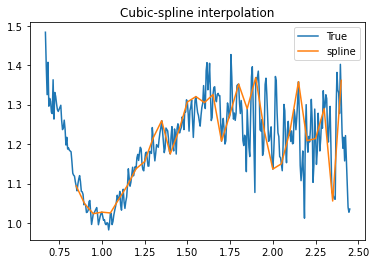

a022099.sp291.txt
Slope: 0.11670888050638155
PC Scores: [-0.19791035 -0.10762009 -0.02876193 -0.03983677 -0.06170411]
Verdict: S, Sq, Q, L, K


'S, Sq, Q, L, K'

In [22]:
classifyAsteroid('D:\\PythonCodes\\JupyterWorkspace\\splat_projects/MITHNEOS_data/sp291/a022099.sp291.txt')

---

### (4660) Nereus 1982 DB, Binzel et al. "IRTF" doi:10.1016/j.pss.2003.10.003 -- Xe $\Rightarrow$ Xe

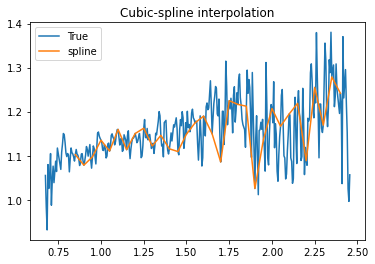

a004660.sp291.txt
Slope: 0.06005230025524034
PC Scores: [-0.05848209  0.21592371  0.04950234 -0.0241872  -0.04740325]
Verdict: X-, C-complexes, L, K, T


'X-, C-complexes, L, K, T'

In [23]:
classifyAsteroid('D:\\PythonCodes\\JupyterWorkspace\\splat_projects/MITHNEOS_data/sp291/a004660.sp291.txt')

---

### (99942) Apophis 2004 MN4 https://cneos.jpl.nasa.gov/doc/apophis/ -- Sq

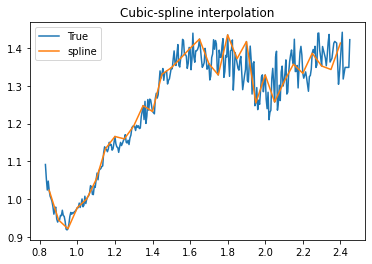

a099942.sp116.txt
Slope: 0.22522465729624533
PC Scores: [-0.04228829 -0.13650555 -0.07991393 -0.0932769  -0.08570363]
Verdict: S, Sq, Q, L, K


'S, Sq, Q, L, K'

In [24]:
classifyAsteroid('D:\\PythonCodes\\JupyterWorkspace\\splat_projects/MITHNEOS_data/sp116/a099942.sp116.txt')

___

---